Loaded 2000 samples with 10 spins each.
[1] Average Energy: -9.7440
[2] Wavefunction norm (raw): 1281.0007


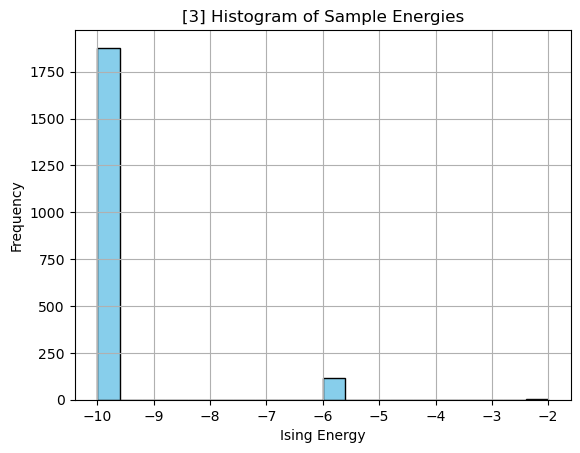

[4] Unique configurations: 29/2000 (1.45%)
[5] Empirical Boltzmann-like weights — Mean: 0.0005, Std: 0.0001


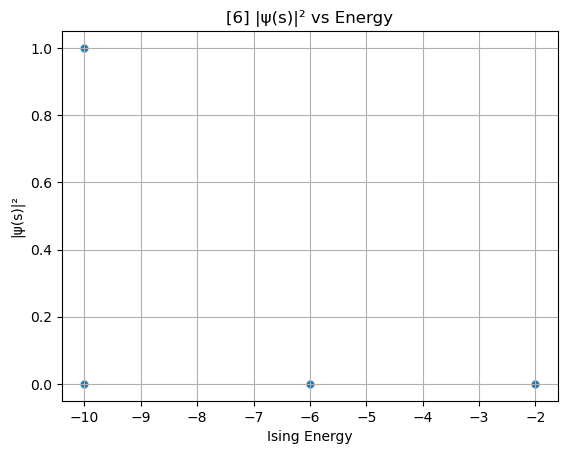

[7] Normalized wavefunction sum: 1.0000 (should be 1.0)


In [37]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load Dataset ===
df = pd.read_csv("rbm_wavefunction_data1.csv")
n_spins = len([col for col in df.columns if col.startswith("s_")])

# Convert spin configs and ψ² values to tensors
spin_cols = [f"s_{i}" for i in range(n_spins)]
spins = torch.tensor(df[spin_cols].values, dtype=torch.float32)
psi_sq = torch.tensor(df["psi_squared"].values, dtype=torch.float32)

print(f"Loaded {spins.shape[0]} samples with {n_spins} spins each.")

# === Helper Functions ===

def ising_energy(configs):
    return -torch.sum(configs * torch.roll(configs, shifts=-1, dims=1), dim=1)

def boltzmann_weight(configs, beta=1.0):
    energies = ising_energy(configs)
    weights = torch.exp(-beta * energies)
    return weights / torch.sum(weights)

# === 1. Average Energy ===
avg_energy = torch.mean(ising_energy(spins)).item()
print(f"[1] Average Energy: {avg_energy:.4f}")

# === 2. Wavefunction Norm Check ===
raw_norm = torch.sum(psi_sq).item()
print(f"[2] Wavefunction norm (raw): {raw_norm:.4f}")

# === 3. Histogram of Energies ===
energies = ising_energy(spins).numpy()
plt.hist(energies, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Ising Energy")
plt.ylabel("Frequency")
plt.title("[3] Histogram of Sample Energies")
plt.grid(True)
plt.show()

# === 4. Unique Configurations ===
unique_spins = torch.unique(spins, dim=0)
print(f"[4] Unique configurations: {unique_spins.shape[0]}/{spins.shape[0]} ({100 * unique_spins.shape[0] / spins.shape[0]:.2f}%)")

# === 5. Boltzmann Distribution Comparison ===
sample_weights = boltzmann_weight(spins)
print(f"[5] Empirical Boltzmann-like weights — Mean: {sample_weights.mean():.4f}, Std: {sample_weights.std():.4f}")

# === 6. Scatter Plot: ψ² vs Energy ===
sns.scatterplot(x=energies, y=psi_sq.numpy(), alpha=0.6)
plt.xlabel("Ising Energy")
plt.ylabel("|ψ(s)|²")
plt.title("[6] |ψ(s)|² vs Energy")
plt.grid(True)
plt.show()

# === 7. Normalized ψ² Check (for ML tasks) ===
psi_sq_normed = psi_sq / torch.sum(psi_sq)
normed_sum = torch.sum(psi_sq_normed).item()
print(f"[7] Normalized wavefunction sum: {normed_sum:.4f} (should be 1.0)")


In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
import itertools

def generate_ising_dataset(n_spins, J=1.0, h=1.0, num_samples=None):
    """
    Generate dataset for 1D Ising model with transverse field.
    
    Parameters:
    -----------
    n_spins: int
        Number of spins in the 1D chain
    J: float
        Coupling strength
    h: float
        Transverse field strength
    num_samples: int or None
        Number of samples to include (None means all 2^n configurations)
        
    Returns:
    --------
    spin_configs: np.ndarray
        Array of spin configurations (shape: [num_samples, n_spins])
    psi_squared: np.ndarray
        Array of |ψ|² values (shape: [num_samples])
    """
    # Step 1: Construct the Hamiltonian matrix
    dim = 2**n_spins
    H = sparse.lil_matrix((dim, dim))
    
    # For each spin configuration
    for idx in range(dim):
        # Convert index to spin configuration
        config = [int(x) for x in format(idx, f'0{n_spins}b')]
        spin_config = [1 if s == 0 else -1 for s in config]  # Map 0->+1, 1->-1
        
        # Add diagonal terms (Ising interaction)
        diag_term = 0
        for i in range(n_spins-1):
            diag_term -= J * spin_config[i] * spin_config[i+1]
        H[idx, idx] = diag_term
        
        # Add off-diagonal terms (transverse field)
        for i in range(n_spins):
            # Flip the i-th spin
            new_config = config.copy()
            new_config[i] = 1 - new_config[i]
            new_idx = int(''.join(map(str, new_config)), 2)
            H[idx, new_idx] = -h
    
    # Step 2: Find the ground state wavefunction
    eigenvalues, eigenvectors = eigsh(H, k=1, which='SA')
    ground_state = eigenvectors[:, 0]
    
    # Ensure wavefunction is real and normalized
    ground_state = np.real(ground_state)
    ground_state = ground_state / np.linalg.norm(ground_state)
    
    # Step 3 & 4: Generate all possible spin configurations and their probabilities
    all_configs = []
    
    # Generate all possible binary strings of length n_spins
    for config_idx in range(dim):
        binary = format(config_idx, f'0{n_spins}b')
        # Convert to spin configuration where 0->+1 and 1->-1
        spin_config = np.array([1 if bit == '0' else -1 for bit in binary])
        all_configs.append(spin_config)
    
    all_configs = np.array(all_configs)
    psi_squared = ground_state**2  # |ψ|² values
    
    # If a specific number of samples is requested, sample from the distribution
    if num_samples is not None and num_samples < dim:
        # Sample based on the probability distribution |ψ|²
        indices = np.random.choice(dim, size=num_samples, p=psi_squared/np.sum(psi_squared))
        spin_configs = all_configs[indices]
        psi_squared_samples = psi_squared[indices]
        return spin_configs, psi_squared_samples
    
    return all_configs, psi_squared

# Example usage:
n_spins = 10  # Adjust based on your needs
configs, probabilities = generate_ising_dataset(n_spins=n_spins, J=1.0, h=1.0)

# Print first few examples
for i in range(5):
    print(f"Configuration: {configs[i]}, |ψ|²: {probabilities[i]:.6f}")

# Save dataset to file
np.savez('ising_dataset.npz', spin_configs=configs, psi_squared=probabilities)

Configuration: [1 1 1 1 1 1 1 1 1 1], |ψ|²: 0.086083
Configuration: [ 1  1  1  1  1  1  1  1  1 -1], |ψ|²: 0.022010
Configuration: [ 1  1  1  1  1  1  1  1 -1  1], |ψ|²: 0.008684
Configuration: [ 1  1  1  1  1  1  1  1 -1 -1], |ψ|²: 0.013057
Configuration: [ 1  1  1  1  1  1  1 -1  1  1], |ψ|²: 0.007462


In [1]:
import numpy as np
from itertools import product

def exact_partition_function(L, T):
    """Calculate exact partition function for small systems (L <= 10)"""
    all_spins = list(product([-1, 1], repeat=L))
    Z = 0
    for spins in all_spins:
        energy = -sum(spins[i] * spins[(i+1)%L] for i in range(L))
        Z += np.exp(-energy / T)
    return Z

def generate_ising_data(L=8, T=2.0, n_samples=2000):
    # 1. Calculate exact partition function (for small systems)
    if L <= 10:
        Z = exact_partition_function(L, T)
    else:
        raise ValueError("For L > 10, use MCMC with normalization tricks (see note at bottom)")
    
    # 2. Generate all possible configurations (only feasible for L <= 10)
    all_spins = list(product([-1, 1], repeat=L))
    
    # 3. Calculate exact probabilities
    probabilities = []
    for spins in all_spins:
        energy = -sum(spins[i] * spins[(i+1)%L] for i in range(L))
        psi_squared = np.exp(-energy / T) / Z
        probabilities.append(psi_squared)
    
    # 4. Sample 2000 configurations according to their probabilities
    all_spins_array = np.array(all_spins)
    prob_array = np.array(probabilities)
    sample_indices = np.random.choice(len(all_spins), size=n_samples, p=prob_array)
    
    # 5. Create dataset
    X = all_spins_array[sample_indices]
    y = prob_array[sample_indices]
    
    return X, y

# Generate dataset for L=8 spins at T=2.0
X, y = generate_ising_data(L=8, T=2.0, n_samples=2000)

# Verify output
print(f"Generated {len(X)} samples")
print("Sample configuration:", X[0])
print("Corresponding ψ²:", y[0])
print("Maximum ψ² in dataset:", np.max(y))


Generated 2000 samples
Sample configuration: [ 1  1  1  1  1 -1 -1  1]
Corresponding ψ²: 0.01101859347470433
Maximum ψ² in dataset: 0.0814170053159015


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from scipy import sparse
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. First generate or load the dataset
def generate_ising_dataset(n_spins, J=1.0, h=1.0, num_samples=None):
    # Step 1: Construct the Hamiltonian matrix
    dim = 2**n_spins
    H = sparse.lil_matrix((dim, dim))
    
    # For each spin configuration
    for idx in range(dim):
        # Convert index to spin configuration
        config = [int(x) for x in format(idx, f'0{n_spins}b')]
        spin_config = [1 if s == 0 else -1 for s in config]  # Map 0->+1, 1->-1
        
        # Add diagonal terms (Ising interaction)
        diag_term = 0
        for i in range(n_spins-1):
            diag_term -= J * spin_config[i] * spin_config[i+1]
        H[idx, idx] = diag_term
        
        # Add off-diagonal terms (transverse field)
        for i in range(n_spins):
            # Flip the i-th spin
            new_config = config.copy()
            new_config[i] = 1 - new_config[i]
            new_idx = int(''.join(map(str, new_config)), 2)
            H[idx, new_idx] = -h
    
    # Step 2: Find the ground state wavefunction
    eigenvalues, eigenvectors = eigsh(H, k=1, which='SA')
    ground_state = eigenvectors[:, 0]
    
    # Ensure wavefunction is real and normalized
    ground_state = np.real(ground_state)
    ground_state = ground_state / np.linalg.norm(ground_state)
    
    # Step 3 & 4: Generate all possible spin configurations and their probabilities
    all_configs = []
    
    # Generate all possible binary strings of length n_spins
    for config_idx in range(dim):
        binary = format(config_idx, f'0{n_spins}b')
        # Convert to spin configuration where 0->+1 and 1->-1
        spin_config = np.array([1 if bit == '0' else -1 for bit in binary])
        all_configs.append(spin_config)
    
    all_configs = np.array(all_configs)
    psi_squared = ground_state**2  # |ψ|² values
    
    # If a specific number of samples is requested, sample from the distribution
    if num_samples is not None and num_samples < dim:
        # Sample based on the probability distribution |ψ|²
        indices = np.random.choice(dim, size=num_samples, p=psi_squared/np.sum(psi_squared))
        spin_configs = all_configs[indices]
        psi_squared_samples = psi_squared[indices]
        return spin_configs, psi_squared_samples, ground_state
    
    return all_configs, psi_squared, ground_state

# Generate dataset for a system with n spins
n_spins = 8
J = 1.0  # Coupling strength
h = 1.0  # Transverse field strength

print(f"Generating dataset for {n_spins}-spin Ising model...")
start_time = time.time()
configs, psi_squared, ground_state_exact = generate_ising_dataset(n_spins, J, h)
print(f"Dataset generated in {time.time() - start_time:.2f} seconds")
print(f"Number of configurations: {len(configs)}")

# Save the original Hamiltonian parameters for use in physics loss
hamiltonian_params = {"J": J, "h": h, "n_spins": n_spins}

# 2. Prepare data for training
# Normalize psi_squared if needed
psi_squared_normalized = psi_squared / np.sum(psi_squared)

# Split data into training and validation sets
train_ratio = 0.8
n_samples = len(configs)
indices = np.random.permutation(n_samples)
train_size = int(train_ratio * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

X_train = configs[train_indices]
y_train = psi_squared_normalized[train_indices]

X_val = configs[val_indices]
y_val = psi_squared_normalized[val_indices]

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# 3. Define the PINN architecture
def create_ising_pinn(n_spins, hidden_layers=[64, 128, 64]):
    
    inputs = keras.layers.Input(shape=(n_spins,))
    x = inputs
    
    # Hidden layers with tanh activation for better gradient flow in PINNs
    for units in hidden_layers:
        x = keras.layers.Dense(units, activation='tanh')(x)
    
    # Output layer: single neuron with softplus activation to ensure positive output
    # We use softplus instead of ReLU for smoother gradients
    outputs = keras.layers.Dense(1, activation='softplus')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create the PINN model
model = create_ising_pinn(n_spins)
model.summary()

# 4. Define physics-informed loss functions
class IsingPINNLoss(keras.losses.Loss):
    def __init__(self, J, h, n_spins, physics_weight=1.0, **kwargs):
        super().__init__(**kwargs)
        self.J = J  # Coupling strength
        self.h = h  # Transverse field strength
        self.n_spins = n_spins
        self.physics_weight = physics_weight  # Weight for physics loss
        
    def call(self, y_true, y_pred):
        # Data loss: Mean squared error between predicted and true |ψ|²
        data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # We'll implement physics loss separately since it needs access to configurations
        return data_loss

# 5. Custom training loop for physics-informed training
@tf.function
def physics_loss(model, spin_configs, J, h):

    # Get all possible configurations for energy computation
    batch_size = tf.shape(spin_configs)[0]
    
    # Compute psi² for original configurations
    with tf.GradientTape() as tape:
        tape.watch(spin_configs)
        psi_squared_pred = model(spin_configs)
    
    # Energy calculation based on the Ising Hamiltonian
    energy_loss = 0.0
    
    # For each configuration, calculate local energy contribution
    for i in range(batch_size):
        config = spin_configs[i]
        # Diagonal energy term (Ising interaction J*σᶻᵢ*σᶻⱼ)
        ising_energy = 0.0
        for j in range(n_spins-1):
            ising_energy -= J * config[j] * config[j+1]
        
        # Transverse field term requires off-diagonal elements
        # We approximate this by computing contributions from spin flips
        transverse_energy = 0.0
        for j in range(n_spins):
            # Create flipped configuration
            flipped_config = tf.identity(config)
            flipped_config = tf.tensor_scatter_nd_update(
                flipped_config, [[j]], [-flipped_config[j]])
            
            # Reshape for model input
            flipped_config_reshaped = tf.reshape(flipped_config, [1, n_spins])
            
            # Get probability amplitude for flipped state
            psi_flipped = tf.sqrt(model(flipped_config_reshaped)[0])
            psi_original = tf.sqrt(psi_squared_pred[i][0])
            
            # Add transverse field contribution
            transverse_energy -= h * (psi_flipped / psi_original)
        
        # Total energy for this configuration
        total_energy = (ising_energy + transverse_energy) * psi_squared_pred[i]
        energy_loss += total_energy
    
    # Average energy across batch
    energy_loss = energy_loss / tf.cast(batch_size, tf.float32)
    
    # Normalization constraint: sum of all probabilities should be close to 1
    norm_loss = tf.abs(tf.reduce_sum(psi_squared_pred) - 1.0)
    
    # Combine losses
    physics_loss = energy_loss + 0.1 * norm_loss
    
    return physics_loss

# Learning rate scheduler with warm-up and decay
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, alpha=0.0, warmup_steps=0):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.alpha = alpha
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        if step < self.warmup_steps:
            return self.initial_learning_rate * (step / self.warmup_steps)
        else:
            cosine_decay = 0.5 * (1 + tf.cos(
                tf.constant(np.pi) * (step - self.warmup_steps) / self.decay_steps))
            decayed = (1 - self.alpha) * cosine_decay + self.alpha
            return self.initial_learning_rate * decayed

# 6. Train the PINN model
def train_ising_pinn(model, X_train, y_train, X_val, y_val, J, h, 
                     batch_size=32, epochs=100, physics_weight_schedule=None):

    if physics_weight_schedule is None:
        # Default: gradually increase physics weight
        physics_weight_schedule = lambda epoch: min(1.0, epoch / (epochs * 0.3))
    
    # Define optimizer with learning rate schedule
    total_steps = epochs * (len(X_train) // batch_size + 1)
    lr_schedule = WarmUpCosineDecay(
        initial_learning_rate=0.001,
        decay_steps=total_steps,
        alpha=0.1,
        warmup_steps=int(total_steps * 0.1)
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Initialize metrics tracking
    train_loss_history = []
    data_loss_history = []
    physics_loss_history = []
    val_loss_history = []
    
    # Create data loaders
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        start_time = time.time()
        
        # Get current physics weight
        current_physics_weight = physics_weight_schedule(epoch)
        
        # Training step
        epoch_train_loss = 0
        epoch_data_loss = 0
        epoch_physics_loss = 0
        batches = 0
        
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                y_pred = model(x_batch)
                
                # Data loss
                data_loss = tf.reduce_mean(tf.square(y_batch - y_pred))
                
                # Physics loss
                phys_loss = physics_loss(model, x_batch, J, h)
                
                # Total loss
                total_loss = data_loss + current_physics_weight * phys_loss
            
            # Backpropagation
            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            # Update metrics
            epoch_train_loss += total_loss.numpy()
            epoch_data_loss += data_loss.numpy()
            epoch_physics_loss += phys_loss.numpy()
            batches += 1
        
        # Average losses for the epoch
        epoch_train_loss /= batches
        epoch_data_loss /= batches
        epoch_physics_loss /= batches
        
        # Validation step
        val_loss = 0
        val_batches = 0
        for x_val, y_val_batch in val_dataset:
            y_val_pred = model(x_val)
            val_batch_loss = tf.reduce_mean(tf.square(y_val_batch - y_val_pred))
            val_loss += val_batch_loss.numpy()
            val_batches += 1
        
        val_loss /= val_batches
        
        # Store history
        train_loss_history.append(epoch_train_loss)
        data_loss_history.append(epoch_data_loss)
        physics_loss_history.append(epoch_physics_loss)
        val_loss_history.append(val_loss)
        
        # Print progress
        time_taken = time.time() - start_time
        print(f"train_loss: {epoch_train_loss:.4f}, data_loss: {epoch_data_loss:.4f}, "
              f"physics_loss: {epoch_physics_loss:.4f}, val_loss: {val_loss:.4f}, "
              f"physics_weight: {current_physics_weight:.2f}, time: {time_taken:.2f}s")
    
    # Return training history
    history = {
        'train_loss': train_loss_history,
        'data_loss': data_loss_history,
        'physics_loss': physics_loss_history,
        'val_loss': val_loss_history
    }
    
    return history

# Physics weight schedule: gradually increase importance of physics loss
def physics_weight_schedule(epoch, max_epochs=100, max_weight=1.0):
    # Start with low weight and linearly increase
    return min(max_weight, 0.05 + (epoch / max_epochs) * max_weight)

# Train model
print("Training PINN model...")
start_time = time.time()
history = train_ising_pinn(
    model, 
    X_train, y_train, 
    X_val, y_val, 
    J=J, h=h,
    batch_size=64, 
    epochs=100,
    physics_weight_schedule=lambda epoch: physics_weight_schedule(epoch, 100, 1.0)
)
print(f"Training completed in {time.time() - start_time:.2f} seconds")

# 7. Evaluate and visualize results
# Plot training history
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history['data_loss'], label='Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Data Loss')

plt.subplot(2, 2, 3)
plt.plot(history['physics_loss'], label='Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Physics Loss')

# Compare predicted vs true |ψ|²
y_pred = model.predict(configs)
y_pred = y_pred.flatten()
y_true = psi_squared_normalized

plt.subplot(2, 2, 4)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')
plt.xlabel('True |ψ|²')
plt.ylabel('Predicted |ψ|²')
plt.title('Prediction vs Ground Truth')

plt.tight_layout()
plt.savefig('ising_pinn_training.png')
plt.show()

# Calculate metrics
mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred)**2)
r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

print(f"Mean Absolute Error: {mae:.6f}")
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.6f}")

# Calculate fidelity between predicted and true wavefunctions
y_pred_normalized = y_pred / np.sum(y_pred)
fidelity = np.sum(np.sqrt(y_pred_normalized * y_true))
print(f"Quantum Fidelity: {fidelity:.6f}")

# Plot the most probable configurations
plt.figure(figsize=(12, 6))

# Top 10 configurations by true probability
top_indices = np.argsort(y_true)[-10:][::-1]
top_configs = configs[top_indices]
top_probs_true = y_true[top_indices]
top_probs_pred = y_pred[top_indices]

plt.subplot(1, 2, 1)
plt.bar(range(10), top_probs_true, alpha=0.6, label='True')
plt.bar(range(10), top_probs_pred, alpha=0.6, label='Predicted')
plt.xlabel('Configuration Index')
plt.ylabel('Probability')
plt.title('Top 10 Most Probable States')
plt.legend()

# Show the spin configurations
plt.subplot(1, 2, 2)
plt.imshow(top_configs, aspect='auto', cmap='coolwarm')
plt.colorbar(label='Spin')
plt.xlabel('Spin Index')
plt.ylabel('Configuration')
plt.title('Top Spin Configurations')

plt.tight_layout()
plt.savefig('ising_pinn_predictions.png')
plt.show()

# Save the trained model
model.save('ising_pinn_model')
print("Model saved successfully.")